As a dual to growing netwotks using evolutionary strategies, can we shrink an over-parametrized network to its optimal structure? The idea would be to fully utilize the parallel computational architecture on hand by training a network that maximizes the throughput of the GPU. Then, iteratively shrink and prune the network.

- Create an over-parametrized or rightly-parametrized network to optimally train the network.
- Inspect each layer and remove layers that are not having an impact on the outcome of the network.
- Layer-wise, apply strong L0 regularization to sparsify the layers.(or something more clever?)
- Recognize motiffs that develop in the network (for example, a chain of neurons that are stretching and splitting the parameter space) and interpret these motiffs as interpretable rules.


Each layer is creating a linear projection of the previous layer, and then cutting (activation function) at some point along each dimension.
Are there (possibly overlapping) subsets of units on each layer that could be grouped together? What are these sets of units doing in terms of the input space? Would an information metric work here?

After network compaction, would it be possible to identify rules that influence the output, for example:

1. Project input neurons $X_1$, $X_3$, and $X_{45}$ using this linear transformation $\Beta_1$. Then, cut the output of this along dimensions 2 and 3 at this value. Call this $T_1$
2. Project input neurons $X_2$, $X_{17}$, and $X_{10}$ using this other linear transformation $\Beta_2$. Then, cut the output of this along dimension 1 at this value. Call this $T_2$
3. Add $T_1$ and $T_2$ and extract this dimension as $Y$.

In [1]:
from dmp.data.pmlb import pmlb_loader
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

import sys
sys.path.append("..")
from networks import get_basic_537_houses
from viz import *

In [2]:
model, inputs, outputs = get_basic_537_houses(num_hidden_layers=6, hidden_layer_width=128, cache_dir="../network_cache")

(20640, 8)
array([[0.90226638],
       [0.70824656],
       [0.69505074],
       ...,
       [0.15938285],
       [0.14371281],
       [0.15340349]])
(20640, 1)
num_observations 20640 num_inputs 8 num_outputs 1
Cache hit, loading type=basic_537_houses-hidden_layer_width=128-num_hidden_layers=6-seed=1 from cache


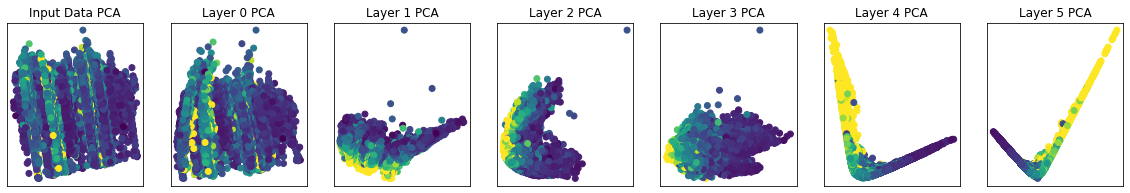

In [3]:
print_layer_pca(model, inputs, outputs)

In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1152      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 1

In [5]:
old_layers = model.layers.copy()
del old_layers[2:6]


layers = [
    tf.keras.layers.Dense(128, activation=tf.nn.relu, input_shape=(8,)),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)]

model_2 = tf.keras.Sequential(layers)

layers[0].set_weights(old_layers[0].get_weights())
layers[1].set_weights(old_layers[1].get_weights())
layers[2].set_weights(old_layers[2].get_weights())


In [6]:
model_2.compile(
        # loss='binary_crossentropy', # binary classification
        # loss='categorical_crossentropy', # categorical classification (one hot)
        loss='mean_squared_error',  # regression
        optimizer=tf.keras.optimizers.Adam(0.001),
        # optimizer='rmsprop',
        # metrics=['accuracy'],
        )


model_2.fit(
    x=inputs,
    y=outputs,
    shuffle=True,
    validation_split=.2,
    # epochs=12,
    epochs=100,
    batch_size=256,
    )

Epoch 1/100
65/65 [==============================] - 1s 10ms/step - loss: 0.0494 - val_loss: 0.0185
Epoch 2/100
65/65 [==============================] - 0s 2ms/step - loss: 0.0200 - val_loss: 0.0183
Epoch 3/100
65/65 [==============================] - 0s 2ms/step - loss: 0.0180 - val_loss: 0.0184
Epoch 4/100
65/65 [==============================] - 0s 2ms/step - loss: 0.0169 - val_loss: 0.0167
Epoch 5/100
65/65 [==============================] - 0s 2ms/step - loss: 0.0163 - val_loss: 0.0168
Epoch 6/100
65/65 [==============================] - 0s 2ms/step - loss: 0.0157 - val_loss: 0.0166
Epoch 7/100
65/65 [==============================] - 0s 2ms/step - loss: 0.0154 - val_loss: 0.0166
Epoch 8/100
65/65 [==============================] - 0s 2ms/step - loss: 0.0151 - val_loss: 0.0171
Epoch 9/100
65/65 [==============================] - 0s 2ms/step - loss: 0.0143 - val_loss: 0.0165
Epoch 10/100
65/65 [==============================] - 0s 2ms/step - loss: 0.0148 - val_loss: 0.0172
Epoch 11

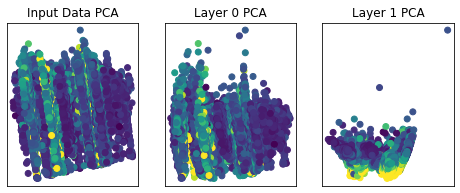

In [7]:
print_layer_pca(model_2, inputs, outputs)

In [8]:
model_2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1152      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 17,793
Trainable params: 17,793
Non-trainable params: 0
_________________________________________________________________


In [9]:
old_layers = model_2.layers.copy()

layers = [
    tf.keras.layers.Dense(128, activation=tf.nn.relu, input_shape=(8,), kernel_regularizer=tf.keras.regularizers.l1(1e-5)),
    tf.keras.layers.Dense(128, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.l1(1e-5)),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid, kernel_regularizer=tf.keras.regularizers.l1(1e-5))]

model_3 = tf.keras.Sequential(layers)

layers[0].set_weights(old_layers[0].get_weights())
layers[1].set_weights(old_layers[1].get_weights())
layers[2].set_weights(old_layers[2].get_weights())


model_3.compile(
        # loss='binary_crossentropy', # binary classification
        # loss='categorical_crossentropy', # categorical classification (one hot)
        loss='mean_squared_error',  # regression
        optimizer=tf.keras.optimizers.Adam(0.001),
        # optimizer='rmsprop',
        # metrics=['accuracy'],
        )


model_3.fit(
    x=inputs,
    y=outputs,
    shuffle=True,
    validation_split=.2,
    # epochs=12,
    epochs=200,
    batch_size=256,
    )

Epoch 1/200
65/65 [==============================] - 1s 3ms/step - loss: 0.0380 - val_loss: 0.0422
Epoch 2/200
65/65 [==============================] - 0s 1ms/step - loss: 0.0339 - val_loss: 0.0392
Epoch 3/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0312 - val_loss: 0.0407
Epoch 4/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0298 - val_loss: 0.0359
Epoch 5/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0283 - val_loss: 0.0352
Epoch 6/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0268 - val_loss: 0.0328
Epoch 7/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0259 - val_loss: 0.0322
Epoch 8/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0253 - val_loss: 0.0322
Epoch 9/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0239 - val_loss: 0.0296
Epoch 10/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0238 - val_loss: 0.0291
Epoch 11/

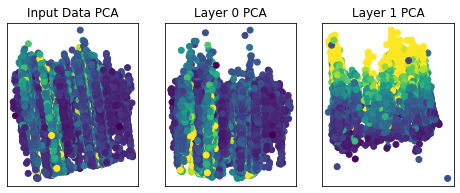

In [10]:
print_layer_pca(model_3, inputs, outputs)

(-0.0025, 0.0025)

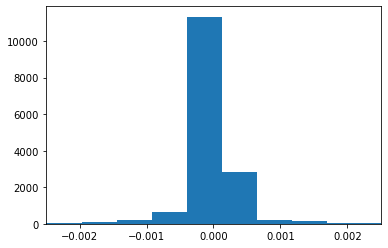

In [22]:
plt.hist(model_3.layers[1].get_weights()[0].flatten(), bins=10000)
plt.xlim(-.0025,.0025)

## Clustering the activations of units within important layers

In [23]:
model.layers[1]

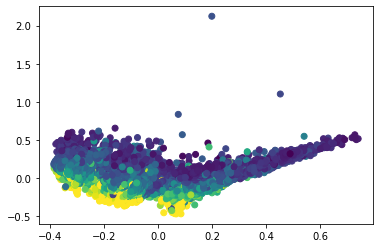

<AxesSubplot:>

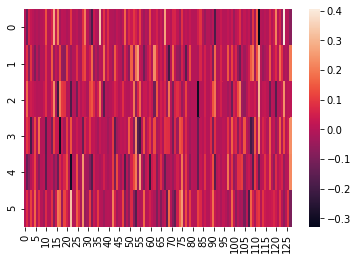

In [24]:
keras_function = tf.keras.backend.function([model.input], [model.layers[1].output])
layerwise_activation = keras_function([inputs])

pca = PCA(6)
out = pca.fit_transform(layerwise_activation[0])
plt.scatter(out[:,0], out[:,1], c=outputs)
plt.show()

sns.heatmap(pca.components_)

/Users/jperrsau/opt/anaconda3/envs/dmp/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


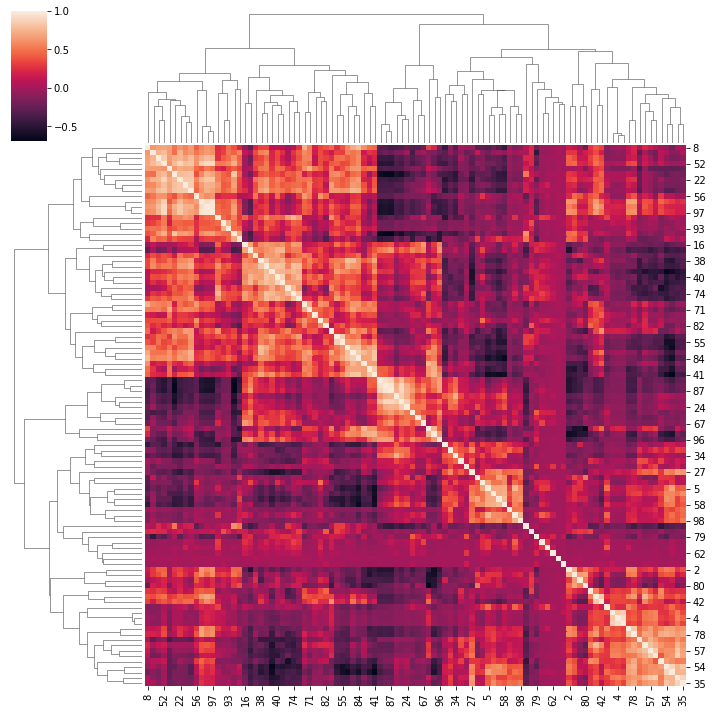

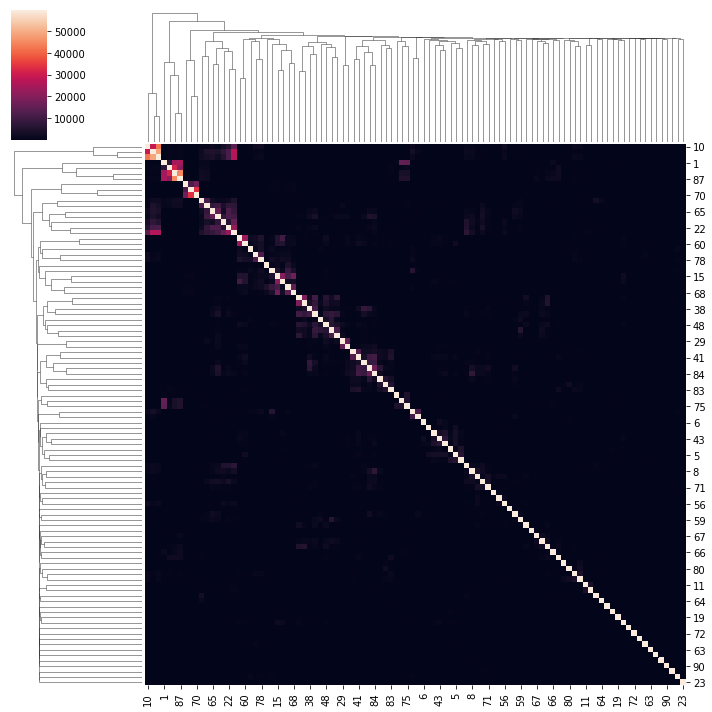

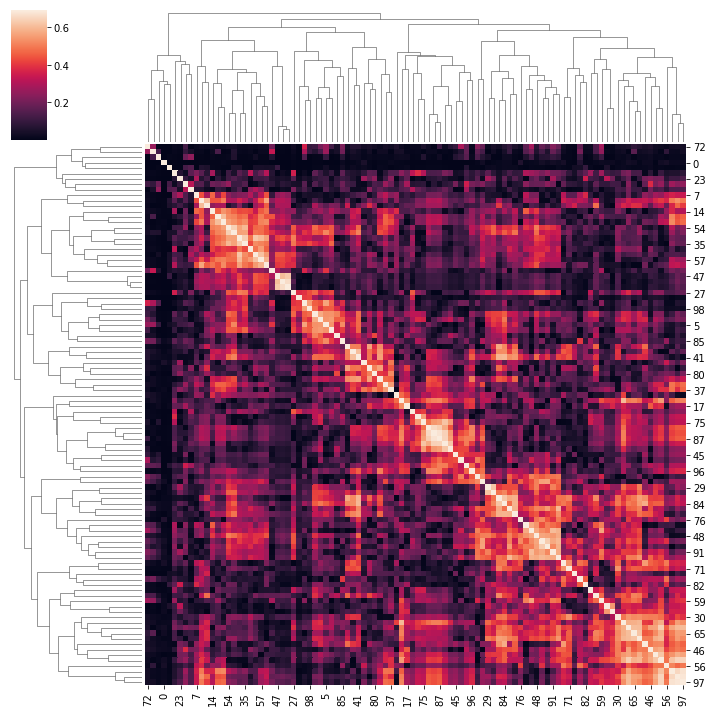

In [25]:
nonzero_std = [np.std(layerwise_activation[0], axis=0) != 0]
cor = np.corrcoef(layerwise_activation[0].T[tuple(nonzero_std)])
sns.clustermap(cor)
sns.clustermap(np.exp(1+10*np.abs(cor)))
sns.clustermap(np.log1p(np.abs(cor)))

In [ ]:
# Can we shrink a big network with the right result push it to be much smaller than is possible to train it?
